<img align="left" src="imgs/logo.jpg" width="50px" style="margin-right:10px">

# Snorkel Workshop: Extracting Spouse Relations <br> from the News
## Part 3: Training the Label Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re

import numpy as np
import pandas as pd

## I. Loading Data

First we'll load our label matrices from notebook 2

In [2]:
import pickle

with open('dev_data.pkl', 'rb') as f:
    dev_df = pickle.load(f)
    dev_labels = pickle.load(f)
    
with open('train_data.pkl', 'rb') as f:
    train_df = pickle.load(f)

with open('dev_L.pkl', 'rb') as f:
    dev_L = pickle.load(f)
    
with open('train_L.pkl', 'rb') as f:
    train_L = pickle.load(f)

## II: Unifying supervision

## Label Model
We know that our labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a factor-graph based label model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which are probabilistic or confidence-weighted labels. We will then use these labels to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers.

### 1. Training the Model
When training the generative model, we'll tune our hyperparamters using a simple grid search. We use `plusminus_to_categorical` to map our labeling convention from `{0,-1,1}` in the previous notebook to `{0,1,2}` as the multiclass convention in this notebook for the `LabelModel`. 

**Parameter Definitions**

    k  Cardinality, or the number of classes in the task
    lr  The factor by which we update model weights after computing the gradient
    class_balance Proportion of [positive, negative] samples in the dataset
    n_epochs     A single pass through all the data in your training set

In [3]:
from snorkel.labeling.model.baselines import MajorityLabelVoter
from snorkel.labeling.model.label_model import LabelModel
from snorkel.analysis.utils import plusminus_to_categorical

label_model = LabelModel(k=2, verbose=True, seed=123)
label_model.train_model(
            plusminus_to_categorical(train_L.toarray()),
            lr = 1e-1,
            class_balance=[0.2,0.8],
            n_epochs=5000,
            log_train_every=500,
        )

Computing O...
Estimating \mu...
[500 epo]: TRAIN:[loss=0.001]
[1000 epo]: TRAIN:[loss=0.001]
[1500 epo]: TRAIN:[loss=0.001]
[2000 epo]: TRAIN:[loss=0.001]
[2500 epo]: TRAIN:[loss=0.001]
[3000 epo]: TRAIN:[loss=0.001]
[3500 epo]: TRAIN:[loss=0.001]
[4000 epo]: TRAIN:[loss=0.001]
[4500 epo]: TRAIN:[loss=0.001]
[5000 epo]: TRAIN:[loss=0.001]
Finished Training


### Label Model Metrics
These are the weights learned for each LF

In [4]:
score = label_model.score((plusminus_to_categorical(dev_L.toarray()), 
                           plusminus_to_categorical(dev_labels)), 
                          metric=['accuracy','f1', 'precision', 'recall'])

Accuracy: 0.905
F1: 0.431
Precision: 0.373
Recall: 0.511
        y=1    y=2   
 l=1    97     163   
 l=2    93    2350   


### Majority Vote Comparison
We can also compare the performance of the LabelModel to computing a majority vote across all the LFs. In case of ties, we guess `2`, which means there is no spouse relationship. This is a common assumption in the information extraction literature

In [5]:
mv_model = MajorityLabelVoter(k=2, verbose=True)
mv_model.train_model(
            plusminus_to_categorical(train_L.toarray()),
        )

score = mv_model.score((plusminus_to_categorical(dev_L.toarray()), 
                           plusminus_to_categorical(dev_labels)), 
                          metric=['accuracy','f1', 'precision', 'recall'], break_ties=2)

Accuracy: 0.814
F1: 0.306
Precision: 0.207
Recall: 0.584
        y=1    y=2   
 l=1    111    425   
 l=2    79    2088   


Note that if we break ties randomly, we get a lower F1 score

In [6]:
score = mv_model.score((plusminus_to_categorical(dev_L.toarray()), 
                           plusminus_to_categorical(dev_labels)), 
                          metric=['accuracy','f1', 'precision', 'recall'], break_ties="random")

Accuracy: 0.451
F1: 0.162
Precision: 0.091
Recall: 0.758
        y=1    y=2   
 l=1    144   1439   
 l=2    46    1074   


### Plotting Probabilistic Labels
One immediate santity check  you can peform using the generative model is to visually examine the distribution of predicted training probabilistic labels. Ideally, there should get a bimodal distribution with large seperation between each peaks, as shown below by the far right image. The corresponds to good signal for true and positive class labels. For your first Snorkel application, you'll probably see probabilistic labels closer to the far left or middle images. With all mass centered around p=0.5, as shown on the **left**, you probably need to write more LFs got get more overall _coverage_. In the **right** image, you have good negative coverage, but not enough positive LFs

<img align="left" src="imgs/marginals-common.jpg" width="265px" style="margin-right:0px">

<img align="center" src="imgs/marginals-real.jpg" width="265px" style="margin-right:0px">

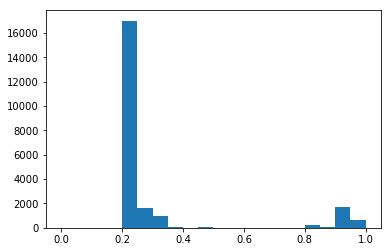

In [7]:
import matplotlib.pyplot as plt
train_proba = label_model.predict_proba(plusminus_to_categorical(train_L.toarray()))
plt.hist(train_proba[:,0], bins=20, range=(0.0, 1.0))
plt.show()

### Saving our training labels

Finally, we'll save the `train_proba`, which are our **"noise-aware training labels"**, so that we can use them to train a downstream machine learning model.

In [8]:
dev_proba = label_model.predict_proba(plusminus_to_categorical(dev_L.toarray()))
with open('dev_proba.pkl', 'wb') as f:
    pickle.dump(dev_proba, f)
    
with open('train_proba.pkl', 'wb') as f:
    pickle.dump(train_proba, f)